## 数据读取与分析

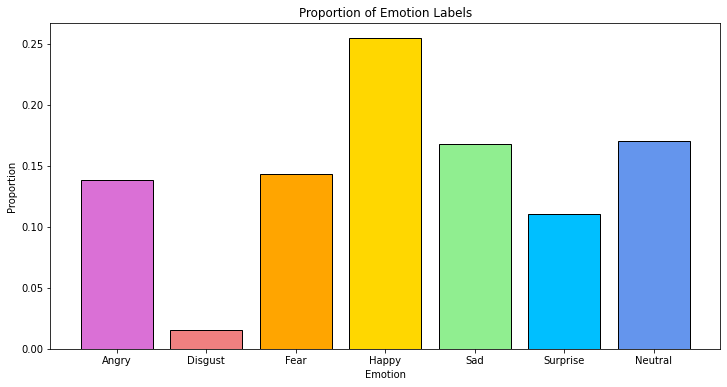

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
train = pd.read_csv('data/train.csv')
emotion_prop = (train.label.value_counts() / len(train)).to_frame().sort_index(ascending=True)
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
palette = ['orchid', 'lightcoral', 'orange', 'gold', 'lightgreen', 'deepskyblue', 'cornflowerblue']

plt.figure(figsize=[12,6])

plt.bar(x=emotions, height=emotion_prop['label'], color=palette, edgecolor='black')
    
plt.xlabel('Emotion')
plt.ylabel('Proportion')
plt.title('Proportion of Emotion Labels')
plt.show()

显然7种情绪在训练集的分布并不均衡

   label                                            feature     Usage
0      0  157 94 9 35 30 20 23 21 23 23 22 21 22 23 26 2...  Training
1      2  77 72 59 54 46 45 41 70 69 76 70 66 66 69 63 7...  Training
2      0  86 83 118 128 138 149 153 156 162 166 170 178 ...  Training
3      6  183 87 51 48 40 35 31 33 45 80 161 198 212 221...  Training
4      6  107 107 107 107 107 107 107 107 107 107 107 10...  Training
Plotting all emotions...


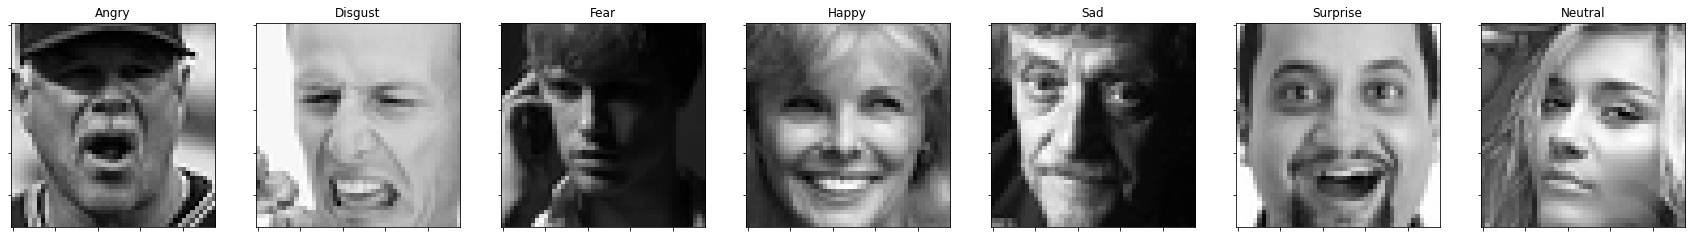

In [2]:
def plot_all_emotions(data):
    print('Plotting all emotions...')
    train_images = np.zeros(shape=(len(data), 48, 48))
    train_labels = np.array(list(map(int, data['label'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'feature'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        train_images[i] = image
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['label']==i].index[i]
        axs[i].imshow(train_images[idx], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx]])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
if __name__ == '__main__':
    print(train.head())
    plot_all_emotions(train)

数据为48x48的单通道灰度图，以上为7种情绪的展示，可以看出仅凭肉眼很难区分

## 保存数据

In [3]:
import csv
import os
import numpy as np
import h5py

file = 'data/train.csv'


Training_x = []
Training_y = []
PublicTest_x = []
PublicTest_y = []
PrivateTest_x = []
PrivateTest_y = []

datapath = os.path.join('data','data.h5')
if not os.path.exists(os.path.dirname(datapath)):
    os.makedirs(os.path.dirname(datapath))

with open(file,'r') as csvin:
    data=csv.reader(csvin)
    for row in data:
        if row[-1] == 'Training':
            temp_list = []
            for pixel in row[1].split( ):
                temp_list.append(int(pixel))
            I = np.asarray(temp_list)
            Training_y.append(int(row[0]))
            Training_x.append(I.tolist())

        if row[-1] == "PublicTest" :
            temp_list = []
            for pixel in row[1].split( ):
                temp_list.append(int(pixel))
            I = np.asarray(temp_list)
            PublicTest_y.append(int(row[0]))
            PublicTest_x.append(I.tolist())

        if row[-1] == 'PrivateTest':
            temp_list = []
            for pixel in row[1].split( ):
                temp_list.append(int(pixel))
            I = np.asarray(temp_list)

            PrivateTest_y.append(int(row[0]))
            PrivateTest_x.append(I.tolist())

print(np.shape(Training_x))
print(np.shape(PublicTest_x))
print(np.shape(PrivateTest_x))

datafile = h5py.File(datapath, 'w')
datafile.create_dataset("Training_pixel", dtype = 'uint8', data=Training_x)
datafile.create_dataset("Training_label", dtype = 'int64', data=Training_y)
datafile.create_dataset("PublicTest_pixel", dtype = 'uint8', data=PublicTest_x)
datafile.create_dataset("PublicTest_label", dtype = 'int64', data=PublicTest_y)
datafile.create_dataset("PrivateTest_pixel", dtype = 'uint8', data=PrivateTest_x)
datafile.create_dataset("PrivateTest_label", dtype = 'int64', data=PrivateTest_y)
datafile.close()

print("Save data finish!")


(16000, 2304)
(2000, 2304)
(2000, 2304)
Save data finish!


由于Leaderboard分为Public和Private两部分，故我将2w个训练集划分为8:1:1的
Training & PublicTest & PrivateTest 三部分，并保存为h5文件，方便后续训练

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import os
from torch.autograd import Variable
from PIL import Image
import torch.utils.data as data
import h5py
class dataset(data.Dataset):
    def __init__(self, split='Training', transform=None):
        self.transform = transform
        self.split = split  # training set or test set
        self.data = h5py.File('./data/data.h5', 'r', driver='core')
        # now load the picked numpy arrays
        if self.split == 'Training':
            self.train_data = self.data['Training_pixel']
            self.train_labels = self.data['Training_label']
            self.train_data = np.asarray(self.train_data)
            self.train_data = self.train_data.reshape((16000, 48, 48))

        elif self.split == 'PublicTest':
            self.PublicTest_data = self.data['PublicTest_pixel']
            self.PublicTest_labels = self.data['PublicTest_label']
            self.PublicTest_data = np.asarray(self.PublicTest_data)
            self.PublicTest_data = self.PublicTest_data.reshape((2000, 48, 48))

        else:
            self.PrivateTest_data = self.data['PrivateTest_pixel']
            self.PrivateTest_labels = self.data['PrivateTest_label']
            self.PrivateTest_data = np.asarray(self.PrivateTest_data)
            self.PrivateTest_data = self.PrivateTest_data.reshape((2000, 48, 48))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.split == 'Training':
            img, target = self.train_data[index], self.train_labels[index]
        elif self.split == 'PublicTest':
            img, target = self.PublicTest_data[index], self.PublicTest_labels[index]
        else:
            img, target = self.PrivateTest_data[index], self.PrivateTest_labels[index]

        # 进行以下操作可以返回pil的图像数据，以确保在其他数据集中也能使用
        img = img[:, :, np.newaxis]
        img = np.concatenate((img, img, img), axis=2)
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        if self.split == 'Training':
            return len(self.train_data)
        elif self.split == 'PublicTest':
            return len(self.PublicTest_data)
        else:
            return len(self.PrivateTest_data)


dataset类，以及一些内置方法

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 7)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

神经网络模型vgg类，实测vgg19效果最佳

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

神经网络模型resnet18,对比得知分数高于vgg19

In [ ]:
import os
import sys
import time
import torch
import torch.nn as nn
term_width = 80 

TOTAL_BAR_LENGTH = 30.
last_time = time.time()
begin_time = last_time

def progress_bar(current, total, msg=None):
    ' Displays or updates a console progress bar. '
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def set_lr(optimizer, lr):
    ' Sets the learning rate to the given value '
    for group in optimizer.param_groups:
        group['lr'] = lr

def clip_gradient(optimizer, grad_clip):
    'Clips gradients computed during backpropagation to avoid explosion of gradients.'
    for group in optimizer.param_groups:
        #print(group['params'])
        for param in group['params']:
            param.grad.data.clamp_(-grad_clip, grad_clip)

训练过程中的三个辅助函数，progress_bar、set_lr、clip_gradient

In [ ]:
path = 'model/'
batch_size = 128
learning_rate = 0.01

use_cuda = torch.cuda.is_available()
best_PublicTest_acc = 0  # best PublicTest accuracy
best_PublicTest_acc_epoch = 0
best_PrivateTest_acc = 0  # best PrivateTest accuracy
best_PrivateTest_acc_epoch = 0
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

learning_rate_decay_start = 80  # 50
learning_rate_decay_every = 5 # 5
learning_rate_decay_rate = 0.9 # 0.9

cut_size = 44
total_epoch = 250
#以上的默认超参数设置

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(44),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

trainset = dataset(split = 'Training', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
PublicTestset = dataset(split = 'PublicTest', transform=transform_test)
PublicTestloader = torch.utils.data.DataLoader(PublicTestset, batch_size=batch_size, shuffle=False)
PrivateTestset = dataset(split = 'PrivateTest', transform=transform_test)
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=batch_size, shuffle=False)

# Model
print('==> Building model..')
#net = VGG('VGG19')
net = ResNet18()


if use_cuda:
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    global Train_acc
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        current_lr = learning_rate * decay_factor
        set_lr(optimizer, current_lr)  # set the decayed rate
    else:
        current_lr = learning_rate
    print('learning_rate: %s' % str(current_lr))

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        with torch.no_grad():
          inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        clip_gradient(optimizer, 0.1)
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

    Train_acc = 100.*correct/total

def PublicTest(epoch):
    global PublicTest_acc
    global best_PublicTest_acc
    global best_PublicTest_acc_epoch
    net.eval()
    PublicTest_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(PublicTestloader):
        bs, ncrops, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
          inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
        loss = criterion(outputs_avg, targets)
        PublicTest_loss += loss.item()
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        progress_bar(batch_idx, len(PublicTestloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                           % (PublicTest_loss / (batch_idx + 1), 100. * correct / total, correct, total))
    
    # Save checkpoint.
    PublicTest_acc = 100.*correct/total
    if PublicTest_acc > best_PublicTest_acc:
        print('Saving..')
        print("best_PublicTest_acc: %0.3f" % PublicTest_acc)
        state = {
            'net': net.state_dict() if use_cuda else net,
            'acc': PublicTest_acc,
            'epoch': epoch,
        }
        if not os.path.isdir(path):
            os.mkdir(path)
        torch.save(state, os.path.join(path,'PublicTest_model.t7'))
        best_PublicTest_acc = PublicTest_acc
        best_PublicTest_acc_epoch = epoch

def PrivateTest(epoch):
    global PrivateTest_acc
    global best_PrivateTest_acc
    global best_PrivateTest_acc_epoch
    net.eval()
    PrivateTest_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
        bs, ncrops, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
          inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
        loss = criterion(outputs_avg, targets)
        PrivateTest_loss += loss.item()
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        progress_bar(batch_idx, len(PublicTestloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (PrivateTest_loss / (batch_idx + 1), 100. * correct / total, correct, total))
    # Save checkpoint.
    PrivateTest_acc = 100.*correct/total

    if PrivateTest_acc > best_PrivateTest_acc:
        print('Saving..')
        print("best_PrivateTest_acc: %0.3f" % PrivateTest_acc)
        state = {
            'net': net.state_dict() if use_cuda else net,
	        'best_PublicTest_acc': best_PublicTest_acc,
            'best_PrivateTest_acc': PrivateTest_acc,
    	    'best_PublicTest_acc_epoch': best_PublicTest_acc_epoch,
            'best_PrivateTest_acc_epoch': epoch,
        }
        if not os.path.isdir(path):
            os.mkdir(path)
        torch.save(state, os.path.join(path,'PrivateTest_model.t7'))
        best_PrivateTest_acc = PrivateTest_acc
        best_PrivateTest_acc_epoch = epoch

for epoch in range(start_epoch, total_epoch):
    train(epoch)
    PublicTest(epoch)
    PrivateTest(epoch)

print("best_PublicTest_acc: %0.3f" % best_PublicTest_acc)
print("best_PublicTest_acc_epoch: %d" % best_PublicTest_acc_epoch)
print("best_PrivateTest_acc: %0.3f" % best_PrivateTest_acc)
print("best_PrivateTest_acc_epoch: %d" % best_PrivateTest_acc_epoch)


==> Preparing data..<br/>
==> Building model..<br/>
==> Training..<br/>

best_PublicTest_acc: 69.300<br/>
best_PublicTest_acc_epoch: 156<br/>
best_PrivateTest_acc: 67.250<br/>
best_PrivateTest_acc_epoch: 103<br/>

训练的主体代码，使用显卡为Quadro RTX 8000的linux服务器运行

In [2]:
import csv
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
Test_x = []
with open('data//test.csv','r') as csvin:
    data=csv.reader(csvin)
    for row in data:
        if row[1] == 'feature':
            continue
        temp_list = []
        for pixel in row[1].split( ):
            temp_list.append(int(pixel))
        I = np.asarray(temp_list)
        Test_x.append(I.tolist())
test_data = np.asarray(Test_x)
test_data = test_data.reshape((8500, 48, 48))
#net = VGG('VGG19')
net = ResNet18()
checkpoint = torch.load(os.path.join('model', 'PublicTest_model.t7'))
# 两份模型可以跑出两个结果
#checkpoint = torch.load(os.path.join('model', 'PrivateTest_model.t7'))
net.load_state_dict(checkpoint['net'])
net.cuda()
net.eval()
cut_size = 44
transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])
pred = []
for gray in test_data:
    img = gray[:, :, np.newaxis]
    img = np.concatenate((img, img, img), axis=2)
    img = Image.fromarray(np.uint8(img))
    inputs = transform_test(img)
    ncrops, c, h, w = np.shape(inputs)
    inputs = inputs.view(-1, c, h, w)
    inputs = inputs.cuda()
    with torch.no_grad():
        inputs = Variable(inputs)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    pred.append(predicted.cpu().numpy())
    #写入csv文件
with open('submission.csv', 'w') as f:
    f.write('id,label\n')
    for i in range(len(pred)):
        f.write(f'{i+1},{pred[i][0]}\n')

把准备提交的结果保存，由于test有两部分，故可以用两个保存下来的模型得到两个结果。因为private数据是未知的，所以两次提交的public分数高低也是未知的